# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E   A   D    DMG      H   MIT    GAME
0   0   7   3   6   5933   1068  6199  DEFEAT
    1   7   0  10   3601    747     0  DEFEAT
    2   9   1   6   4352      0     0  DEFEAT
    3   7   7   2   2332   6325     0  DEFEAT
    4   6   4   2   3410   5979   606  DEFEAT
...    ..  ..  ..    ...    ...   ...     ...
453 5  18   7  12   8122      0  7417  DEFEAT
    6  28   0  14  10590      0  2985  DEFEAT
    7  21   1  12   8113    756    56  DEFEAT
    8   8  17   9   2548  10580  1212  DEFEAT
    9  13  15  14   5175   8684   511  DEFEAT

[4540 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4540 entries, (0, 0) to (453, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       4540 non-null   int64 
 1   A       4540 non-null   int64 
 2   D       4540 non-null   int64 
 3   DMG     4540 non-null   int64 
 4   H       4540 non-null   int64 
 5   MIT     4540 non-null   int64 
 6   GAME    4540 non-null   object
dtypes: int64(6), object(1)
memory usage: 281.7+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,4540.000000,4540.000000,4540.000000,4540.000000,4540.000000,4540.000000
mean,13.690529,7.219604,6.403524,6183.030837,3824.042511,2376.745154
std,9.610504,8.181975,3.878092,4323.759153,5065.306762,4636.667843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2722.500000,0.000000,0.000000
50%,12.000000,4.000000,6.000000,5449.500000,712.500000,341.500000
75%,20.000000,11.250000,9.000000,9088.500000,7415.750000,1943.250000
max,58.000000,54.000000,21.000000,26666.000000,27756.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E   A   D    DMG      H   MIT    GAME
0   0   7   3   6   5933   1068  6199  DEFEAT
    1   7   0  10   3601    747     0  DEFEAT
    2   9   1   6   4352      0     0  DEFEAT
    3   7   7   2   2332   6325     0  DEFEAT
    4   6   4   2   3410   5979   606  DEFEAT
...    ..  ..  ..    ...    ...   ...     ...
453 5  18   7  12   8122      0  7417  DEFEAT
    6  28   0  14  10590      0  2985  DEFEAT
    7  21   1  12   8113    756    56  DEFEAT
    8   8  17   9   2548  10580  1212  DEFEAT
    9  13  15  14   5175   8684   511  DEFEAT

[4540 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,17.705947,4.272026,6.122247,9002.320485,295.941630,9715.105727
std,10.276899,3.698954,3.720297,4163.284459,897.602303,6049.768546
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,3.000000,5905.500000,0.000000,5463.500000
50%,17.000000,3.000000,6.000000,8810.000000,0.000000,8586.500000
75%,24.000000,6.000000,8.000000,11659.000000,0.000000,12919.750000
max,58.000000,24.000000,21.000000,24682.000000,12607.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000
mean,17.022026,1.796256,7.045154,8210.982379,345.665198,604.269824
std,9.217456,2.527710,4.104174,3705.715964,560.433664,1062.213022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5516.250000,0.000000,0.000000
50%,16.000000,1.000000,7.000000,7842.500000,0.000000,70.000000
75%,23.000000,3.000000,10.000000,10531.000000,517.750000,785.750000
max,52.000000,18.000000,21.000000,26666.000000,3353.000000,8306.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000
mean,8.351322,14.116740,5.902533,2745.434471,9066.470264,480.040198
std,6.748854,8.533365,3.626027,2108.041539,4197.223391,814.217997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,3.000000,1203.750000,6070.500000,0.000000
50%,7.000000,13.000000,6.000000,2428.500000,8646.500000,189.000000
75%,12.000000,19.000000,8.000000,3760.250000,11569.500000,605.000000
max,52.000000,54.000000,21.000000,16254.000000,27756.000000,7778.000000


그림 저장:tank_hist


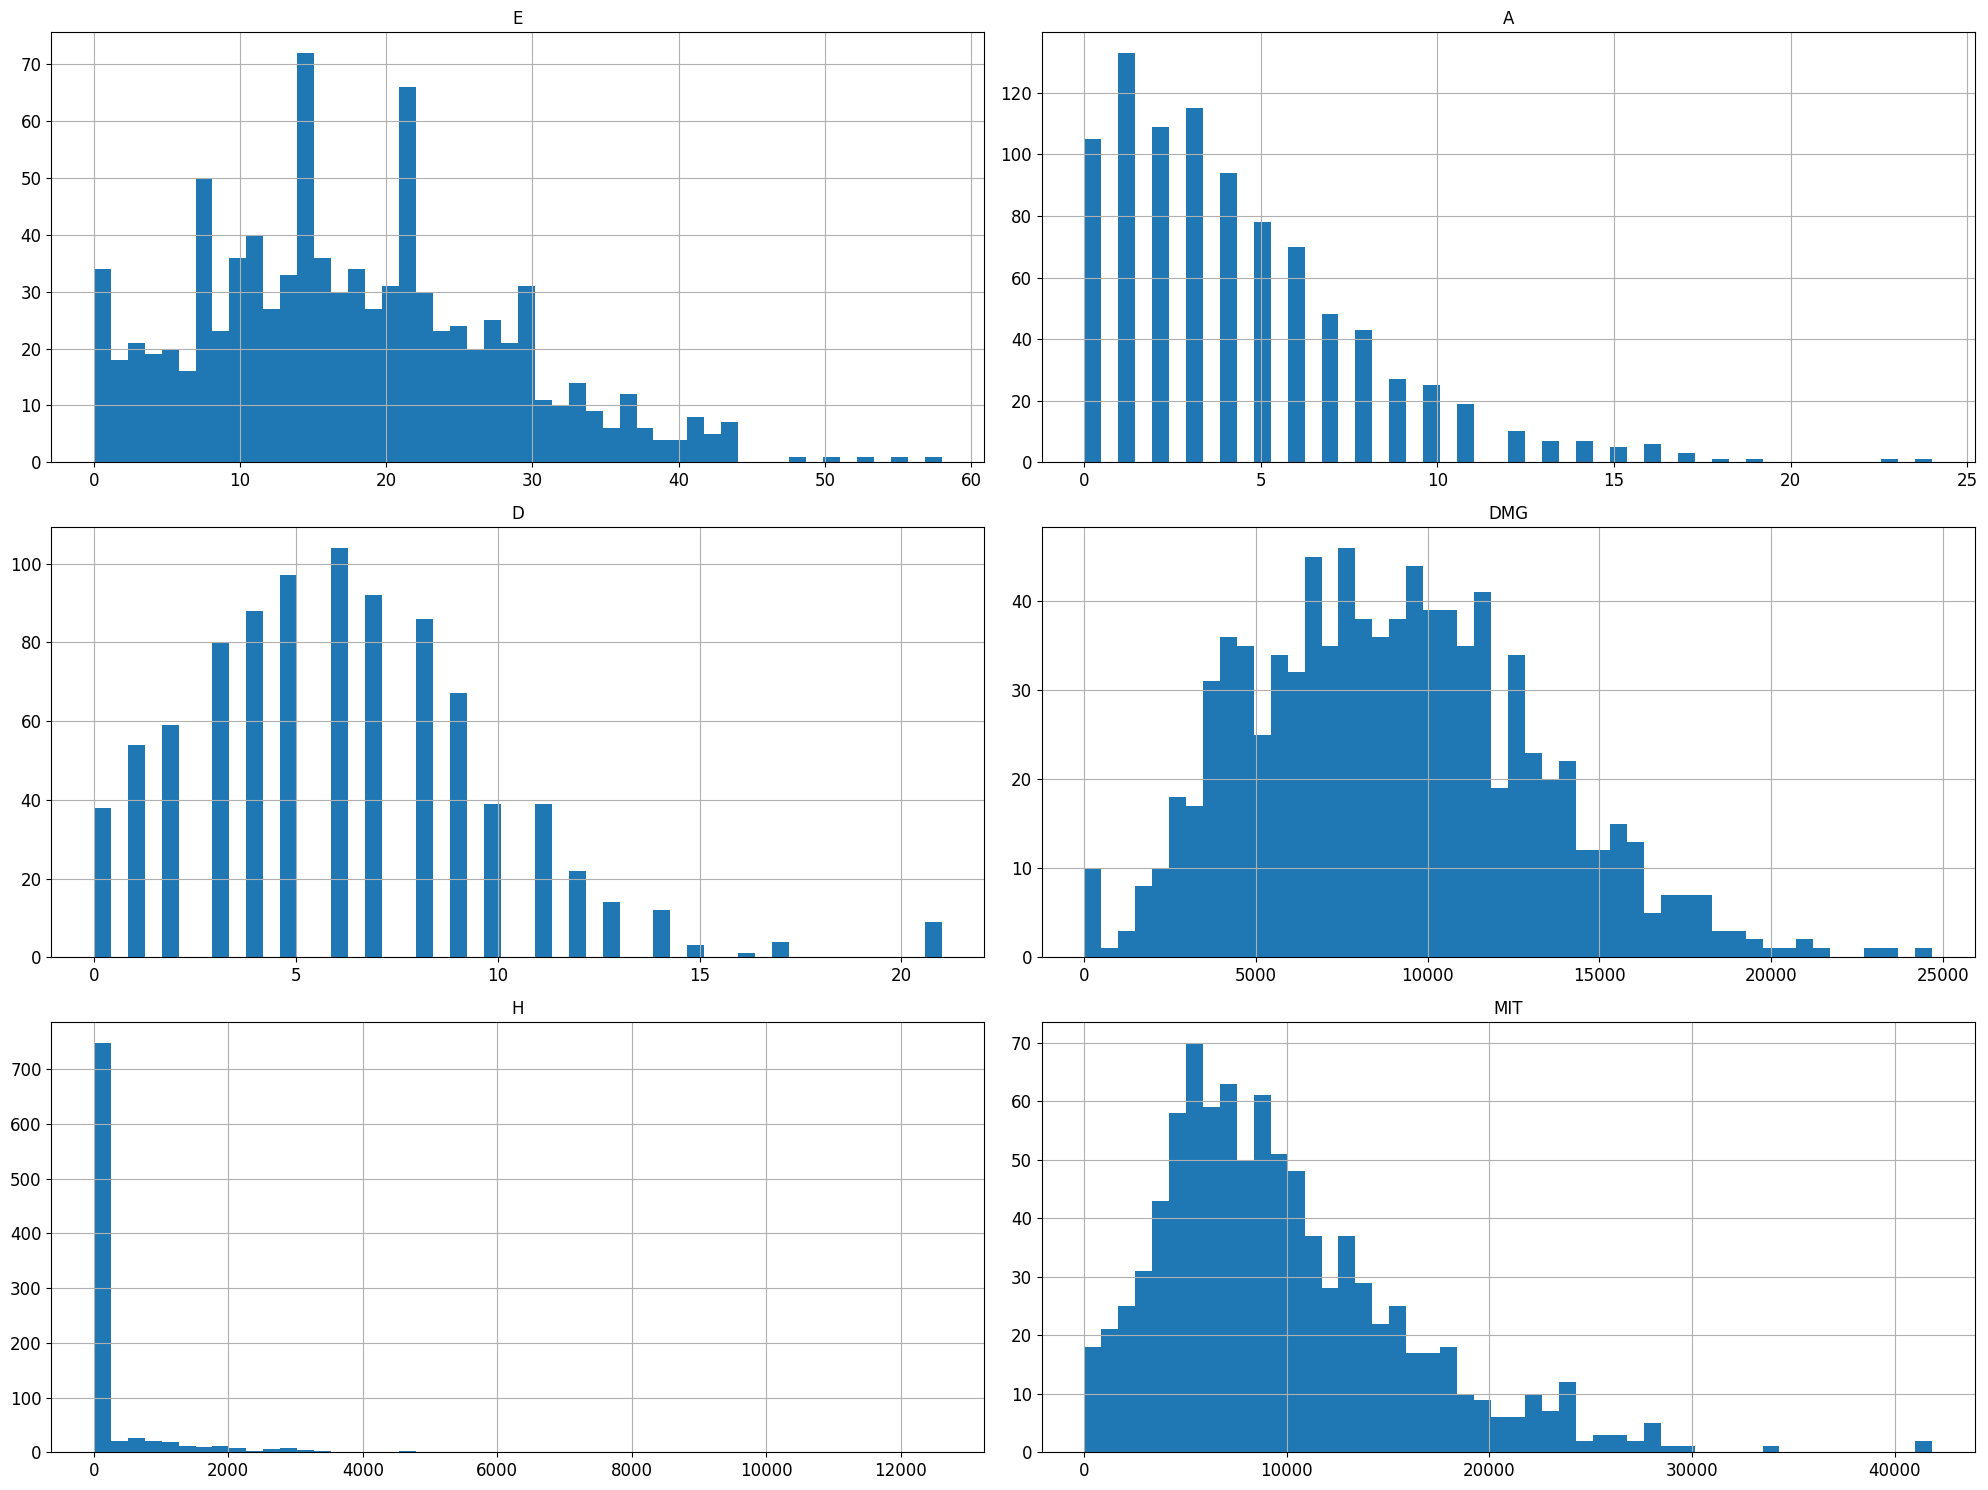

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


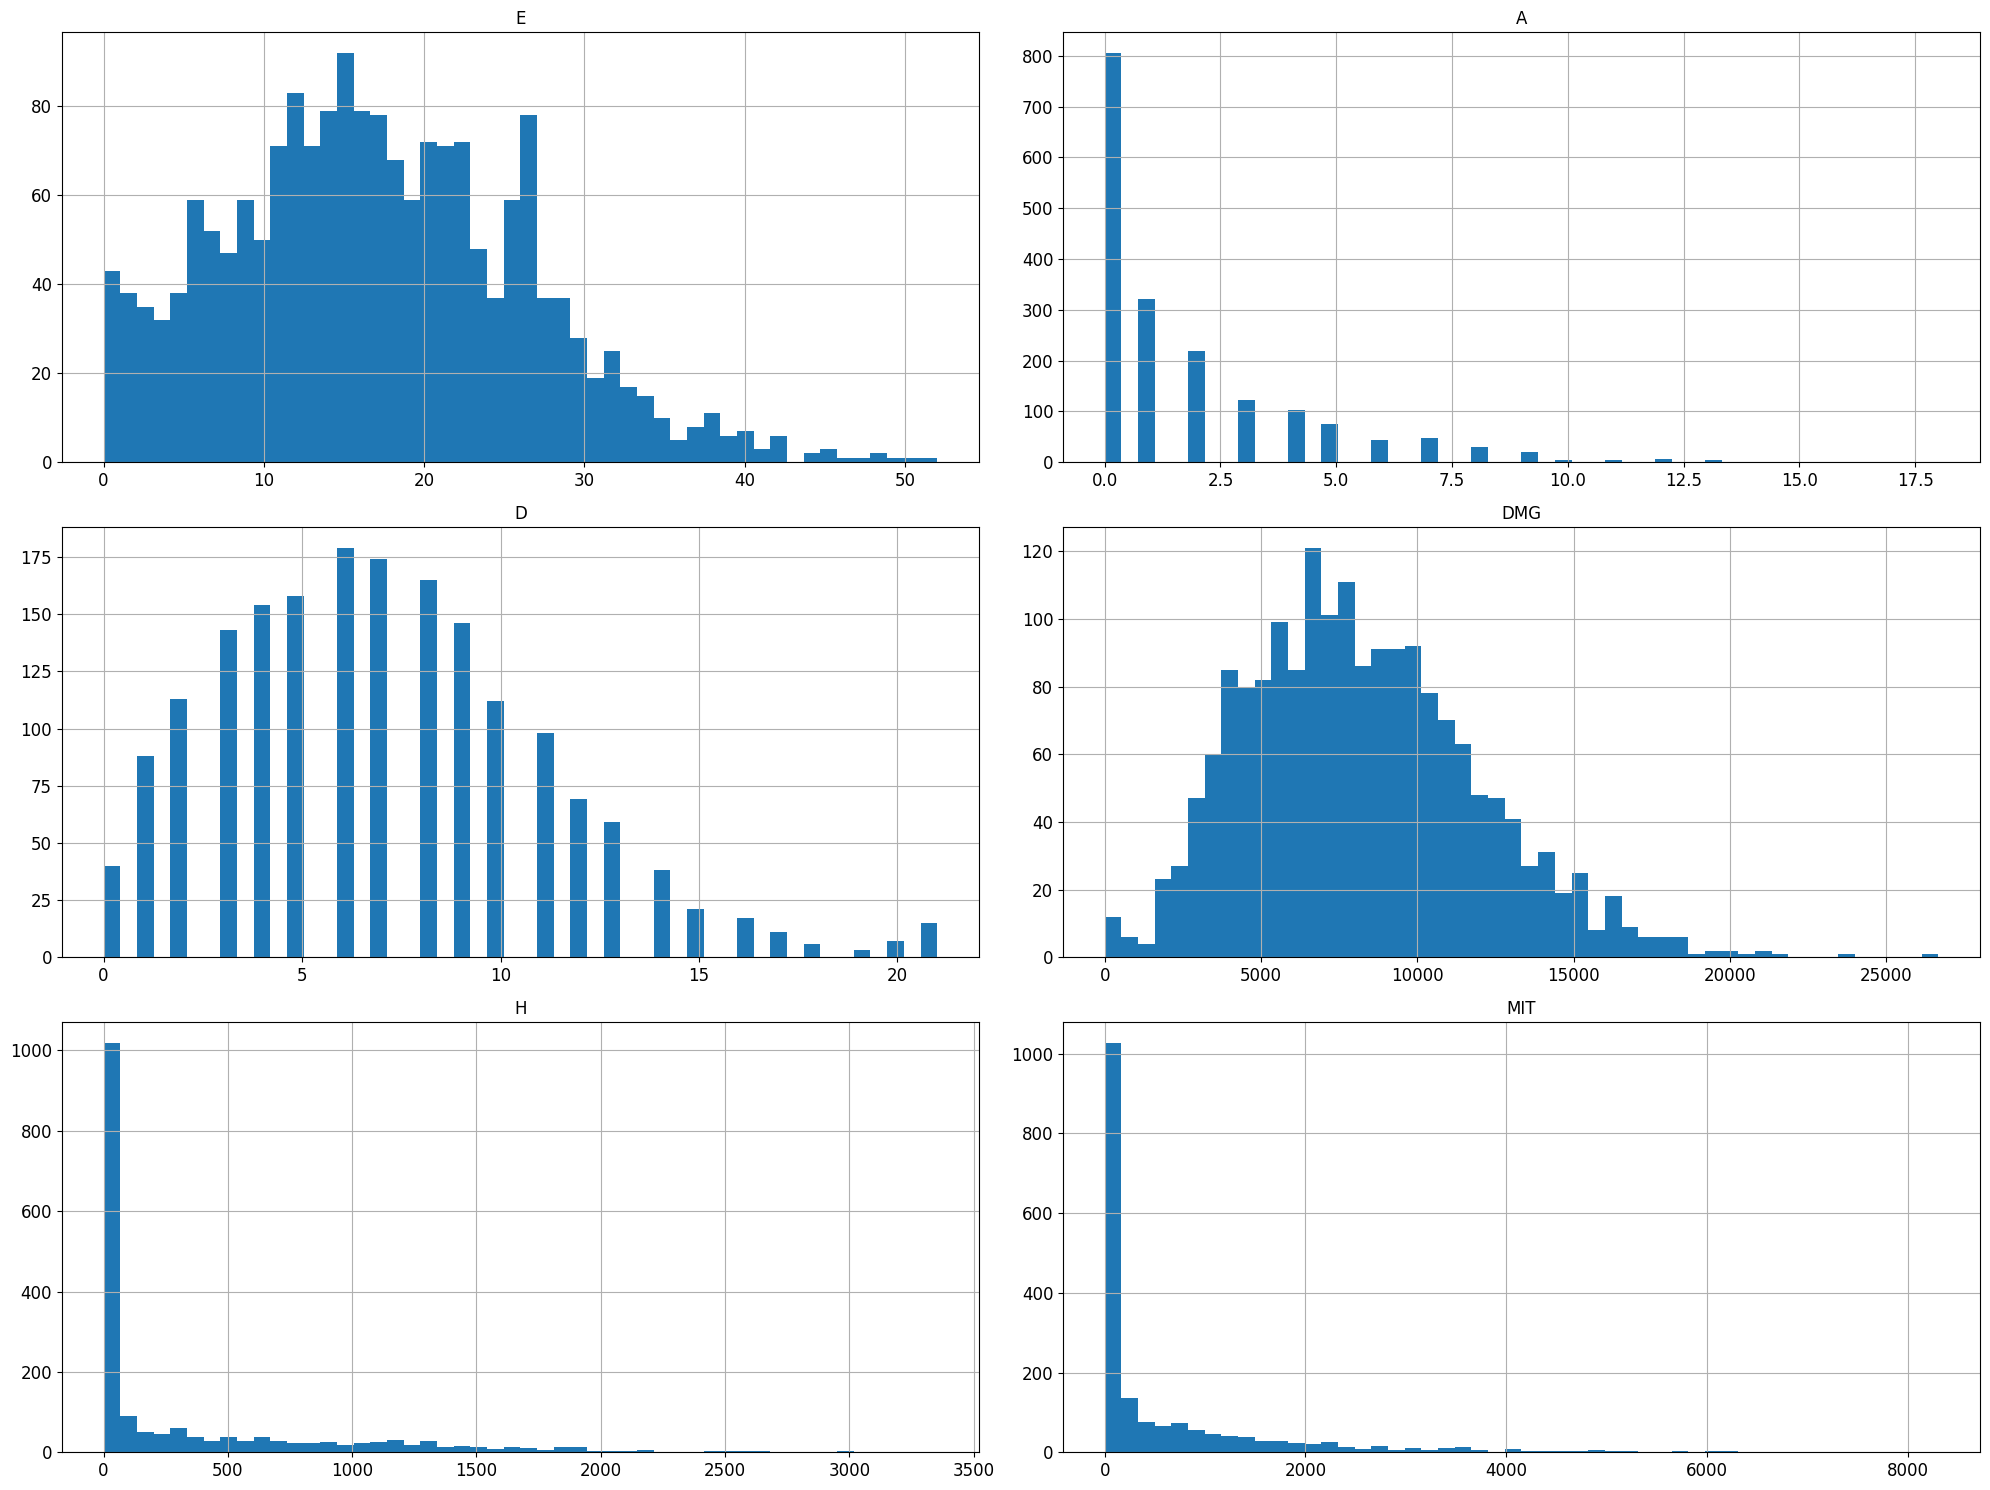

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


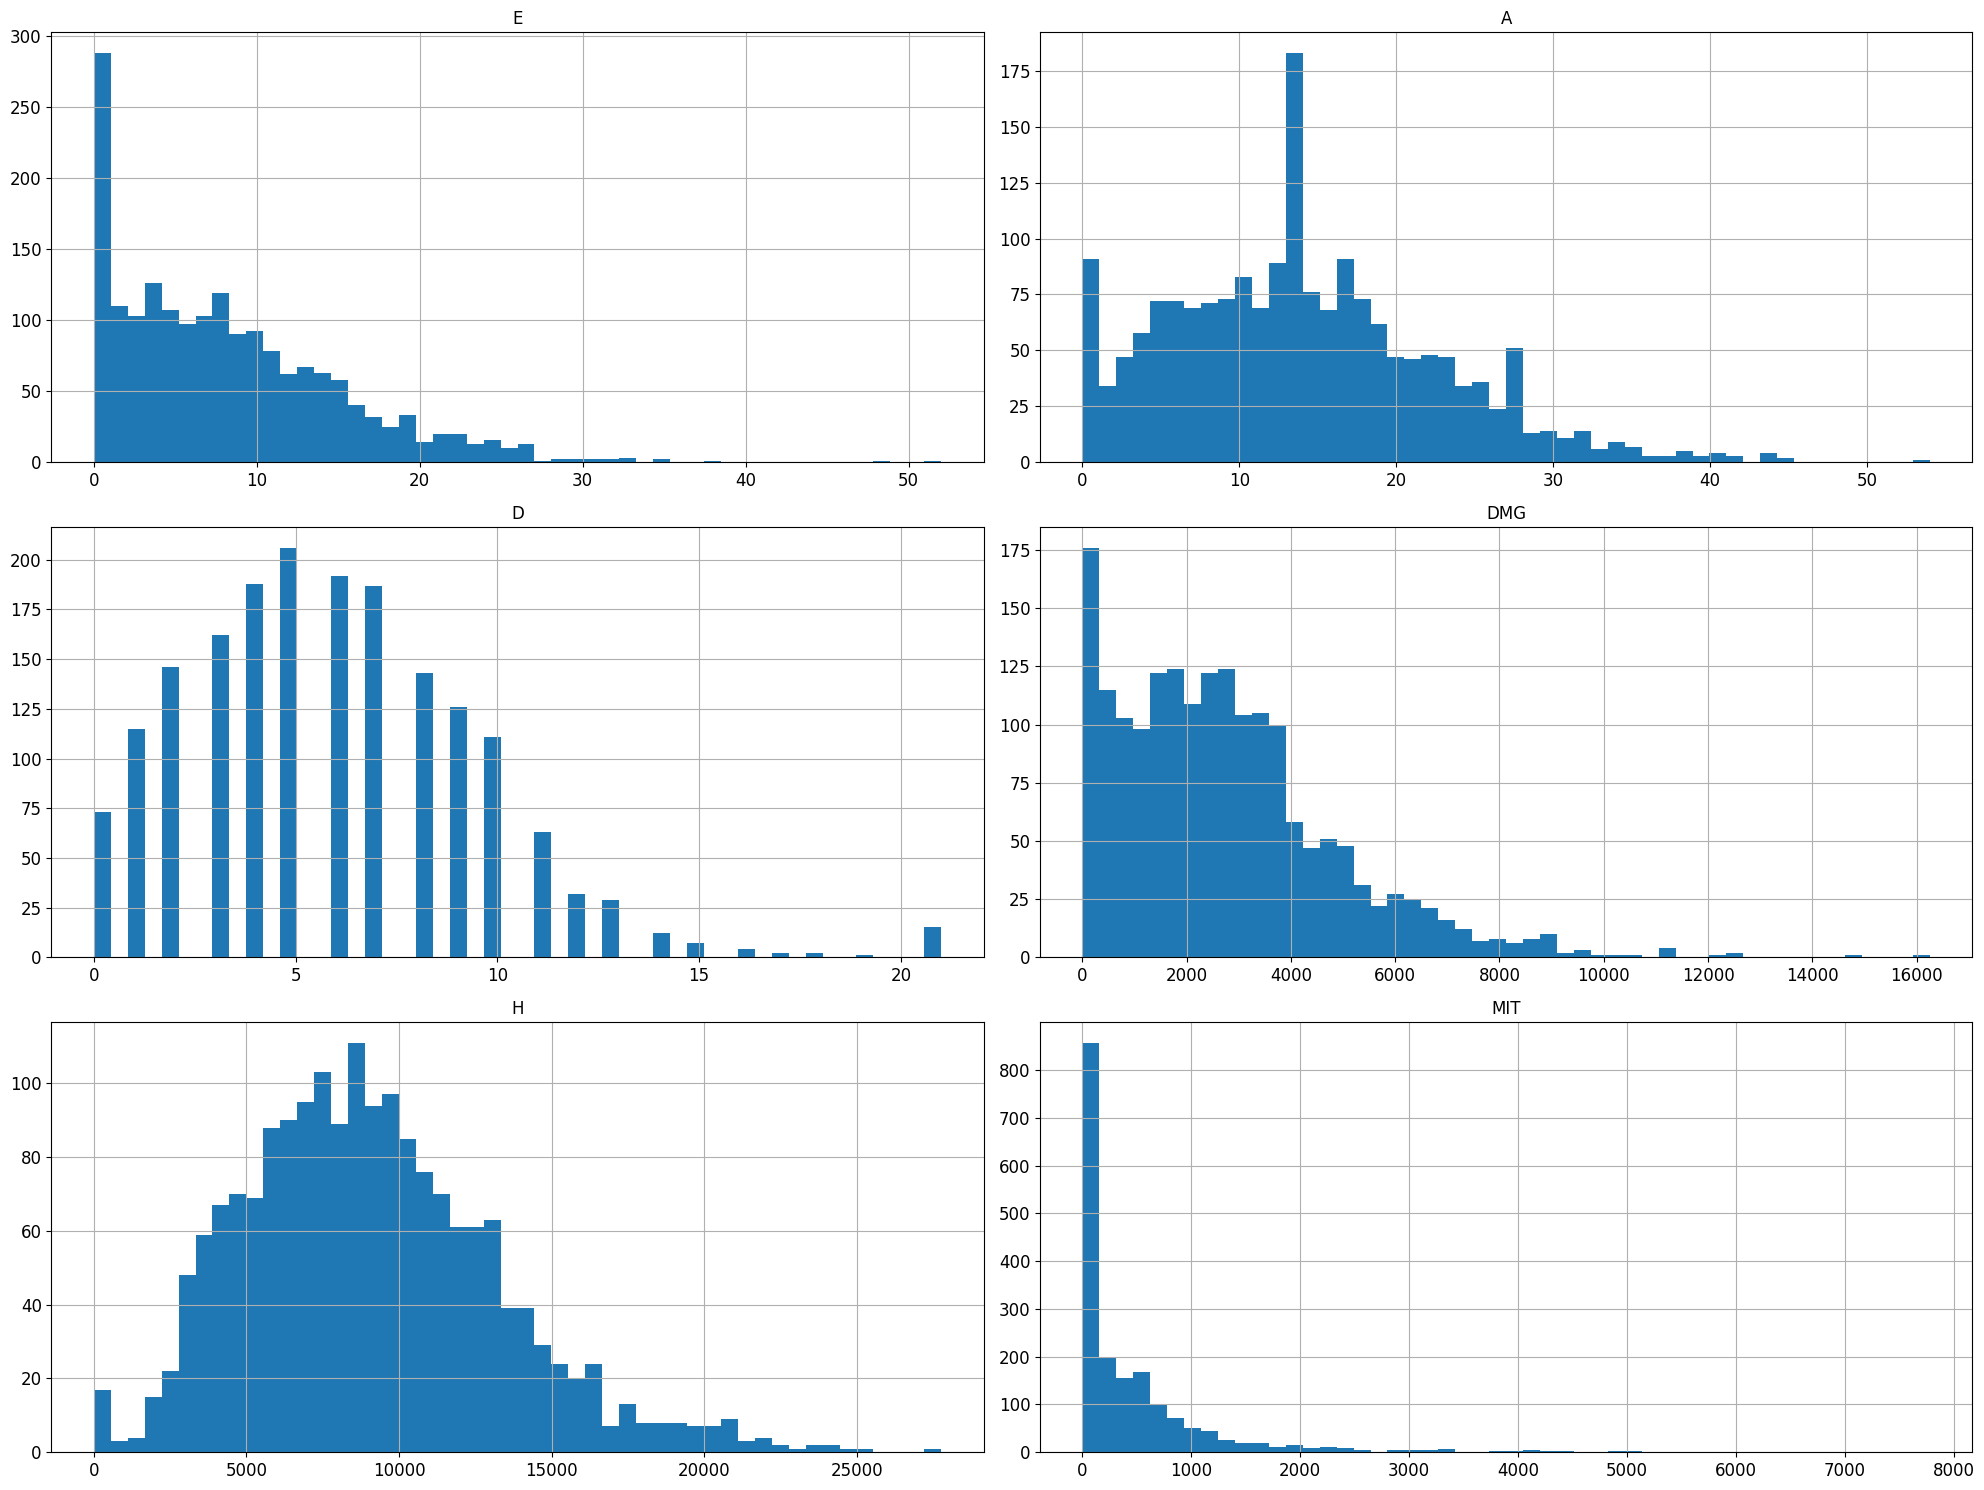

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E   A  D    DMG      H   MIT     GAME
332 0  34   8  6  13643      0  5489  VICTORY
    1  46   5  5  15013      0     0  VICTORY
    2  31   6  9  14540   1488     0  VICTORY
    3  15  19  5   5904  11859  1576  VICTORY
    4   1  35  4    207  12230     0  VICTORY
...    ..  .. ..    ...    ...   ...      ...
187 5  10   2  1   4365      0  4292  VICTORY
    6  15   0  0   5505    555     0  VICTORY
    7  10   1  0   4051    448  3305  VICTORY
    8   4   8  1    781   6335   360  VICTORY
    9  11  12  0   2672   4109     0  VICTORY

[4540 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
332 0  0.586207  0.148148  0.285714  0.511625  0.000000  0.131162
    1  0.793103  0.092593  0.238095  0.563002  0.000000  0.000000
    2  0.534483  0.111111  0.428571  0.545264  0.053610  0.000000
    3  0.258621  0.351852  0.238095  0.221406  0.427259  0.037659
    4  0.017241  0.648148  0.190476  0.007763  0.440625  0.000000
...         ...       ...       ...       ...       ...       ...
187 5  0.172414  0.037037  0.047619  0.163692  0.000000  0.102559
    6  0.258621  0.000000  0.000000  0.206443  0.019996  0.000000
    7  0.172414  0.018519  0.000000  0.151916  0.016141  0.078974
    8  0.068966  0.148148  0.047619  0.029288  0.228239  0.008602
    9  0.189655  0.222222  0.000000  0.100203  0.148040  0.000000

[4540 rows x 6 columns]

---

In [16]:
X_ = X.copy()
X_['D'] = 1 - X_['D']

---

In [17]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(454, 60)
(454,)


In [18]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.89010989, 0.93406593, 0.91208791, 0.85714286, 0.91111111])

In [19]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.52747253, 0.56043956, 0.54945055, 0.53846154, 0.6       ])

In [20]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.87912088, 0.87912088, 0.86813187, 0.87912088, 0.91111111])

In [21]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

[(Perceptron(n_jobs=-1), 0.9052747252747253),
 (LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.9009035409035409),
 (LogisticRegression(n_jobs=-1), 0.8965079365079365),
 (RidgeClassifierCV(), 0.8965079365079365),
 (NuSVC(), 0.8943345543345543),
 (RidgeClassifier(), 0.8920879120879122),
 (NearestCentroid(), 0.8920879120879122),
 (SVC(), 0.8899145299145299),
 (RandomForestClassifier(n_jobs=-1), 0.88989010989011),
 (LinearSVC(dual='auto'), 0.8876923076923078),
 (ExtraTreesClassifier(n_jobs=-1), 0.8832967032967034),
 (MLPClassifier(max_iter=3200), 0.8745543345543346),
 (KNeighborsClassifier(n_jobs=-1), 0.8723076923076925),
 (SGDClassifier(n_jobs=-1), 0.8722344322344323),
 (GradientBoostingClassifier(), 0.8612942612942615),
 (HistGradientBoostingClassifier(), 0.8524786324786324),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.845958485958486),
 (AdaBoostClassifier(), 0.8370451770451771),
 (BaggingClassifier(n_jobs=-1), 0.8304517704517703),
 (DecisionTreeClassifier(), 0.7996092796092796),
 (E

In [22]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [23]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        print(estimator)

        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tank = importances[tanks].sum(0)
        importances_damage = importances[damages].sum(0)
        importances_support = importances[supports].sum(0)
        importances[tanks] = importances_tank / 2
        importances[damages] = importances_damage / 4
        importances[supports] = importances_support / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('\n**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip(
                    (importances_tank.sum(), importances_damage.sum(), importances_support.sum()),
                    ('돌격(2)', '공격(4)', '지원(4)')
                ),
                reverse=True
        ):
            print(f'{title}: {importance:.3f}')

        print('\n**돌격(2) 특성 중요도**')
        for importance, title in sorted(zip(importances_tank, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**공격(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_damage, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**지원(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_support, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        break

RandomForestClassifier(n_jobs=-1)

**특성 중요도**
처치: 0.353
죽음: 0.254
도움: 0.179
피해: 0.103
경감: 0.058
치유: 0.053

**역할 중요도**
지원(4): 0.352
공격(4): 0.348
돌격(2): 0.300

**돌격(2) 특성 중요도**
죽음: 0.130
처치: 0.096
피해: 0.029
도움: 0.026
경감: 0.015
치유: 0.004

**공격(4) 특성 중요도**
처치: 0.197
죽음: 0.052
피해: 0.042
경감: 0.020
치유: 0.019
도움: 0.017

**지원(4) 특성 중요도**
도움: 0.136
죽음: 0.072
처치: 0.060
피해: 0.033
치유: 0.029
경감: 0.023


---

In [24]:
import numpy as np

In [51]:
sum_ = X_.sum(1)
sum_n = sum_ / sum_.sum()
print(f'{sum_n.std():f}')
sum_ = (X_ * np.tile(importances, (len(X_.index) // 10, 1))).sum(1)
sum_m = sum_ / sum_.sum()
print(f'{sum_m.std():f}')
sum_ = (X_ / np.tile(importances, (len(X_.index) // 10, 1))).sum(1)
sum_d = sum_ / sum_.sum()
print(f'{sum_d.std():f}')

0.000059
0.000121
0.000069


In [79]:
tanks_ = sum_n.iloc[[i for i in range(len(sum_n.index)) if i % 10 in (0, 5)]]
damages_ = sum_n.iloc[[i for i in range(len(sum_n.index)) if i % 10 in (1, 2, 6, 7)]]
supports_ = sum_n.iloc[[i for i in range(len(sum_n.index)) if i % 10 in (3, 4, 8, 9)]]
means = np.array((tanks_.mean(), damages_.mean(), supports_.mean()))
means /= means.sum()
print(means)
print(means.std())

[0.3665606  0.29050395 0.34293545]
0.03178368607700733


In [80]:
tanks_ = sum_m.iloc[[i for i in range(len(sum_m.index)) if i % 10 in (0, 5)]]
damages_ = sum_m.iloc[[i for i in range(len(sum_m.index)) if i % 10 in (1, 2, 6, 7)]]
supports_ = sum_m.iloc[[i for i in range(len(sum_m.index)) if i % 10 in (3, 4, 8, 9)]]
means = np.array((tanks_.mean(), damages_.mean(), supports_.mean()))
means /= means.sum()
print(means)
print(means.std())

[0.55868557 0.21838347 0.22293096]
0.15935891146814132


In [64]:
tanks_ = sum_d.iloc[[i for i in range(len(sum_d.index)) if i % 10 in (0, 5)]]
damages_ = sum_d.iloc[[i for i in range(len(sum_d.index)) if i % 10 in (1, 2, 6, 7)]]
supports_ = sum_d.iloc[[i for i in range(len(sum_d.index)) if i % 10 in (3, 4, 8, 9)]]
means = np.array((tanks_.mean(), damages_.mean(), supports_.mean()))
means /= means.sum()
print(means)
print(means.std())

[0.27571664 0.33329401 0.39098936]
0.04705989893490164


In [77]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -10):
    defeat_i = defeat[i:i + 10]
    print(f'DEFEAT ({i // 10 + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    print(contributions.round(3))
    contributions = contributions.sum(1)
    contributions *= 10 / contributions.sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

DEFEAT (211)
       E   A   D    DMG      H    MIT     GAME
2100  21   2   7  11491      0  15412   DEFEAT
2101  23   1  15  11041      0    268   DEFEAT
2102  25   1   9  13574   1125      0   DEFEAT
2103   9  16   7   4155   8716    378   DEFEAT
2104   2  25   7    240  12712    865   DEFEAT
2105  20   3   7  14119      0   6721  VICTORY
2106  25   8   9  10727    286    982  VICTORY
2107  28   9   8   9879      0      0  VICTORY
2108   4  13  11   1712  10017    401  VICTORY
2109  10  21   4   2034  14057    277  VICTORY
[[0.362 0.037 0.667 0.431 0.    0.368]
 [0.397 0.019 0.286 0.414 0.    0.006]
 [0.431 0.019 0.571 0.509 0.041 0.   ]
 [0.155 0.296 0.667 0.156 0.314 0.009]
 [0.034 0.463 0.667 0.009 0.458 0.021]
 [0.345 0.056 0.667 0.529 0.    0.161]
 [0.431 0.148 0.571 0.402 0.01  0.023]
 [0.483 0.167 0.619 0.37  0.    0.   ]
 [0.069 0.241 0.476 0.064 0.361 0.01 ]
 [0.172 0.389 0.81  0.076 0.506 0.007]]
TEAM 1: 1.2 0.7 1.0 1.0 1.0
TEAM 2: 1.1 1.0 1.0 0.8 1.2

DEFEAT (210)
       E 

In [66]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -10):
    victory_i = victory[i:i + 10]
    print(f'VICTORY ({i // 10 + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions = contributions.sum(1)
    contributions *= 10 / contributions.sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

VICTORY (243)
       E   A   D    DMG      H    MIT     GAME
2420  36   3   6  11425      0  18862  VICTORY
2421  33   4   9  11017   3057      0  VICTORY
2422  36   0   5   9860      0   1417  VICTORY
2423  21  23  11   4096   7658    405  VICTORY
2424  17  32   8   4631   8997   3093  VICTORY
2425  18   7  12   8122      0   7417   DEFEAT
2426  28   0  14  10590      0   2985   DEFEAT
2427  21   1  12   8113    756     56   DEFEAT
2428   8  17   9   2548  10580   1212   DEFEAT
2429  13  15  14   5175   8684    511   DEFEAT
TEAM 1: 1.4 1.1 1.1 1.0 1.3
TEAM 2: 0.8 0.8 0.7 0.9 0.8

VICTORY (242)
       E   A   D    DMG      H    MIT     GAME
2410  38   8   5  13438      0  21994  VICTORY
2411  38   7   6  14521   2526      0  VICTORY
2412  37   0  13  10160     59   1991  VICTORY
2413  21  30  10   5948   8129   1401  VICTORY
2414   8  44   5   1256  13781      0  VICTORY
2415  29  10  14  14491      0  19682   DEFEAT
2416  16   5  12   9802    253      0   DEFEAT
2417  16   0  12   911

---

In [75]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

DEFEAT (211)
       E   A   D    DMG      H    MIT     GAME
2100  21   2   7  11491      0  15412   DEFEAT
2101  23   1  15  11041      0    268   DEFEAT
2102  25   1   9  13574   1125      0   DEFEAT
2103   9  16   7   4155   8716    378   DEFEAT
2104   2  25   7    240  12712    865   DEFEAT
2105  20   3   7  14119      0   6721  VICTORY
2106  25   8   9  10727    286    982  VICTORY
2107  28   9   8   9879      0      0  VICTORY
2108   4  13  11   1712  10017    401  VICTORY
2109  10  21   4   2034  14057    277  VICTORY
TEAM 1: 1.0 0.8 1.0 1.0 1.1
TEAM 2: 1.0 1.0 1.1 0.7 1.2

DEFEAT (210)
       E   A   D    DMG      H    MIT     GAME
2090   9   3  15   8763   1061   2726   DEFEAT
2091  11   4   4   9532     15   5760   DEFEAT
2092  15   1  13   7547   1288      0   DEFEAT
2093   3   2   9   3873   3780     40   DEFEAT
2094   3  10   9    858  14060   1411   DEFEAT
2095  38  12   4  14203    549  10479  VICTORY
2096  25   7   5   7266      0      0  VICTORY
2097  28   4   5   9395 

In [76]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

VICTORY (243)
       E   A   D    DMG      H    MIT     GAME
2420  36   3   6  11425      0  18862  VICTORY
2421  33   4   9  11017   3057      0  VICTORY
2422  36   0   5   9860      0   1417  VICTORY
2423  21  23  11   4096   7658    405  VICTORY
2424  17  32   8   4631   8997   3093  VICTORY
2425  18   7  12   8122      0   7417   DEFEAT
2426  28   0  14  10590      0   2985   DEFEAT
2427  21   1  12   8113    756     56   DEFEAT
2428   8  17   9   2548  10580   1212   DEFEAT
2429  13  15  14   5175   8684    511   DEFEAT
TEAM 1: 1.3 1.1 1.2 1.0 1.3
TEAM 2: 0.7 0.9 0.7 0.9 0.8

VICTORY (242)
       E   A   D    DMG      H    MIT     GAME
2410  38   8   5  13438      0  21994  VICTORY
2411  38   7   6  14521   2526      0  VICTORY
2412  37   0  13  10160     59   1991  VICTORY
2413  21  30  10   5948   8129   1401  VICTORY
2414   8  44   5   1256  13781      0  VICTORY
2415  29  10  14  14491      0  19682   DEFEAT
2416  16   5  12   9802    253      0   DEFEAT
2417  16   0  12   911

In [ ]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(layers.Dense(300, 'relu', input_shape=(total_features,)))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

In [ ]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', ['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]